Open the dataset bike_rides.csv

In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


What is the mean value of the column containing the information of sin(α)Vd

In [2]:
import numpy as np

# build the data matrix
data_linear_model = pd.concat(
    {"speed^3": data["speed"] ** 3,
     "speed": data["speed"],
     "speed*sin(alpha)": data["speed"] * np.sin(np.arctan(data["slope"])),
     "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)},
    axis=1
)
data_linear_model.mean()["speed*sin(alpha)"]

-0.0027097096125663312

On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to?  

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit

model = make_pipeline(StandardScaler(), RidgeCV())
cv = ShuffleSplit(n_splits=4)

cv_results = cross_validate(model, data_linear_model, target,
                            cv=cv, scoring='neg_mean_absolute_error',
                            return_estimator=True, return_train_score=True)

In [4]:
errors = -cv_results["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [73.52674575 71.07253187 71.34089614 74.43357158]
 mean +/- std: 72.593 +/- 1.426 Watts


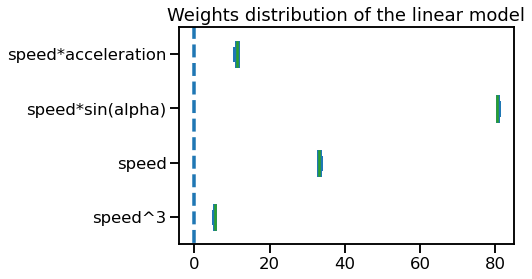

In [5]:
import matplotlib.pyplot as plt
coefs = [
    estimator[-1].coef_ for estimator in cv_results["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_linear_model.columns)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=42
)

cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=cv, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True, n_jobs=2)

errors = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [44.39516221 44.13036203 43.75817    43.06094014]
 mean +/- std: 43.836 +/- 0.502 Watts


In [7]:
errors_SS_lm = -cv_results["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")
errors_SS_lm = -cv_results["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")

errors_SS_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")
errors_SS_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.459 +/- 0.175 Watts
Linear model - MAE on test sets:	 72.593 +/- 1.426 Watts
Histogram GBDT - MAE on train sets:	 40.561 +/- 0.686 Watts
Histogram GBDT - MAE on test sets:	 43.836 +/- 0.502 Watts


With the histogram gradient boosting, the testing error is higher than the training error. This symptomatic of a model capable of overfitting.  
The testing and training error of the linear model are very close. However, the errors are much higher than the histogram gradient boosting. The linear model is clearly underfitting.

In [8]:
import numpy as np

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


In [9]:
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data_linear_model.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    model, data_linear_model, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors_LOGO_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")
errors_LOGO_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")

errors_LOGO_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
errors_LOGO_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.249 +/- 2.247 Watts
Linear model - MAE on test sets:	 73.015 +/- 5.779 Watts
Histogram GBDT - MAE on train sets:	 40.131 +/- 1.295 Watts
Histogram GBDT - MAE on test sets:	 49.204 +/- 2.694 Watts


Regarding model under- and over-fitting, we observe the same behaviour as with the ShuffleSplit strategy: the linear model is still limited by underfitting while the histogram gradient boosting regressor is still overfitting.

We also see that the histogram gradient boosting regressor is more clearly overfitting with the LeaveOneGroupOut cross-validation strategy as the gap between train and test scores is even wider than measured with the ShuffleSplit strategy.

Thus, even if the linear model is modelling the true physical problem, it probably suffers from shortcomings imposed by missing measurements (for instance wind speed) and by the uncertainty of some measurements (for instance GPS error). As a result, the linear model is not as accurate as the histogram gradient boosting regressor that has access to external measurements. The additional information, such as the heart-rate and the cadence, attenuate the previous shortcomings.

In [10]:
print(
    "LM with LeaveOneGroupOut has a bigger test error than LM with ShuffleSplit by "
    f"{errors_LOGO_lm.mean() - errors_SS_lm.mean()}"
    " Watts."
)

LM with LeaveOneGroupOut has a bigger test error than LM with ShuffleSplit by 0.4213389164790158 Watts.


In [11]:
print(
    "HGBDT with LeaveOneGroupOut has a bigger test error than HGBDT with ShuffleSplit by "
    f"{errors_LOGO_hgbdt.mean() - errors_SS_hgbdt.mean()}"
    " Watts."
)

HGBDT with LeaveOneGroupOut has a bigger test error than HGBDT with ShuffleSplit by 5.367504740249601 Watts.


In [12]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

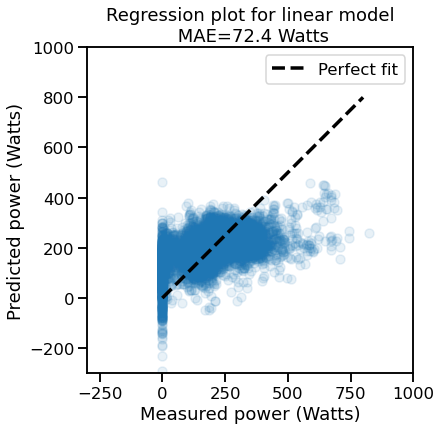

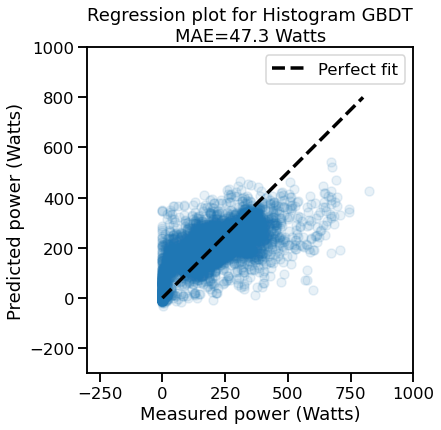

In [13]:
from sklearn.metrics import mean_absolute_error

# fit models and collect predictions
model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = model.predict(data_linear_model_test)

hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

We see that both the linear model and the histogram gradient boosting regressor always predict power below the measured power. Indeed, high power samples correspond to sprints effort. When measuring speed and acceleration, there is a sort of delay to observe this change while measuring the power directly apply on the pedals will not suffer from such issue.

On the other hand, we see that the linear model predicts catastrophic negative power for samples with a power of 0 Watt. This is due to our modeling. Indeed, the power based on the change of kinetic energy (power needed to accelerate or decelerate) is producing such artifacts. Indeed, we do not model the power loss introduced by heat dissipation when braking to reduce the speed of the bike (to take a bend for instance) and therefore, we get non-sense value for samples with low power. The histogram gradient boosting regressor uses instead the cadence since 0 rpm (rotation per minute) will be linked with 0 Watt produced.

In [14]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

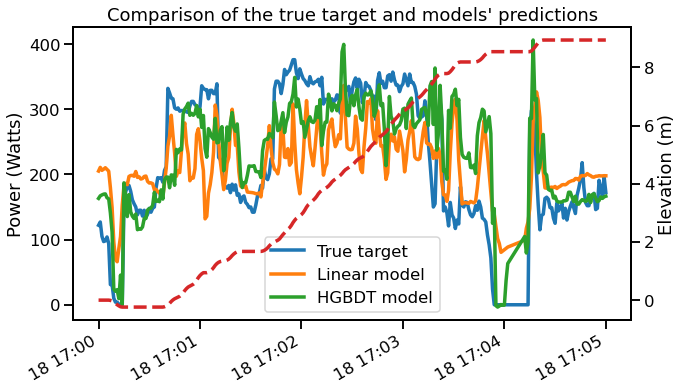

In [15]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")

We see that the linear model has predictions that are more off from the true target than the predictions from the histogram gradient boosting regressor. While the histogram gradient boosting regressor is able to make abrupt changes of the power, the linear model is unable to predict abrupt changes and need time to output the level of true power.

Again the comparatively bad performance of the linear regression model trained on the physically meaningful features does not necessarily stem from errors in the feature engineering but might come from the GPS measurement errors that prevent a precise estimation of short changes in the speed and acceleration.

The gradient boosting model might be able to workaround those limitations of the GPS errors via the more precise heart rate and cadence measurements.